## 🔧 1. Setup & Check GPU

In [1]:
# Install packages jika belum ada
# !pip install torch transformers scikit-learn pandas numpy matplotlib seaborn tqdm pynvml

import torch
import sys
import platform
import subprocess

print('=' * 60)
print('🖥️  SYSTEM INFO')
print('=' * 60)
print(f'Python: {sys.version}')
print(f'PyTorch: {torch.__version__}')
print(f'Platform: {platform.system()} {platform.release()}')
print()

# Check GPU
if torch.cuda.is_available():
    print('✅ CUDA is available!')
    print(f'   GPU: {torch.cuda.get_device_name(0)}')
    print(f'   CUDA Version: {torch.version.cuda}')
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f'   Total Memory: {gpu_memory:.1f} GB')
    device = torch.device('cuda')
    
    # Check nvidia-smi untuk power info
    try:
        result = subprocess.run(['nvidia-smi', '--query-gpu=power.limit,power.draw', '--format=csv,noheader,nounits'], 
                               capture_output=True, text=True)
        if result.returncode == 0:
            power_info = result.stdout.strip().split(',')
            print(f'   Power Limit: {float(power_info[0].strip()):.0f} W')
            print(f'   Current Power: {float(power_info[1].strip()):.1f} W')
    except:
        print('   Power info: nvidia-smi not available')
else:
    print('⚠️ CUDA not available, using CPU')
    print('   Training will be SLOW!')
    device = torch.device('cpu')

print(f'\n🎮 Using device: {device}')

🖥️  SYSTEM INFO
Python: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
PyTorch: 2.1.2+cu118
Platform: Windows 10

✅ CUDA is available!
   GPU: NVIDIA GeForce RTX 4070
   CUDA Version: 11.8
   Total Memory: 12.0 GB
   Power Limit: 200 W
   Current Power: 31.6 W

🎮 Using device: cuda


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, 
    classification_report, confusion_matrix, f1_score
)
from sklearn.utils import resample
import random
import os
import copy
import json
from datetime import datetime
import time
import subprocess

warnings.filterwarnings('ignore')

# =====================================================
# GPU MONITORING FUNCTIONS
# =====================================================
def get_gpu_memory_usage():
    """Get current GPU memory usage in MB"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(0) / 1024**2
        reserved = torch.cuda.memory_reserved(0) / 1024**2
        return allocated, reserved
    return 0, 0

def get_gpu_power():
    """Get current GPU power draw in Watts"""
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=power.draw', '--format=csv,noheader,nounits'],
            capture_output=True, text=True
        )
        if result.returncode == 0:
            return float(result.stdout.strip())
    except:
        pass
    return 0.0

def get_gpu_stats():
    """Get comprehensive GPU stats"""
    if not torch.cuda.is_available():
        return None
    
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=memory.used,memory.total,power.draw,temperature.gpu,utilization.gpu', 
             '--format=csv,noheader,nounits'],
            capture_output=True, text=True
        )
        if result.returncode == 0:
            values = [v.strip() for v in result.stdout.strip().split(',')]
            return {
                'memory_used_mb': float(values[0]),
                'memory_total_mb': float(values[1]),
                'power_draw_w': float(values[2]),
                'temperature_c': float(values[3]),
                'gpu_util_percent': float(values[4])
            }
    except:
        pass
    return None

class GPUMonitor:
    """Monitor GPU usage during training"""
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.memory_samples = []
        self.power_samples = []
        self.start_time = None
        self.end_time = None
        self.total_energy_wh = 0
    
    def start(self):
        self.reset()
        self.start_time = time.time()
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
    
    def sample(self):
        """Take a sample of current GPU stats"""
        if torch.cuda.is_available():
            mem_allocated = torch.cuda.memory_allocated(0) / 1024**2
            self.memory_samples.append(mem_allocated)
            
            power = get_gpu_power()
            if power > 0:
                self.power_samples.append(power)
    
    def stop(self):
        self.end_time = time.time()
        
        # Calculate total energy consumption
        if self.power_samples and self.start_time:
            duration_hours = (self.end_time - self.start_time) / 3600
            avg_power = np.mean(self.power_samples)
            self.total_energy_wh = avg_power * duration_hours
    
    def get_summary(self):
        """Get summary of GPU usage"""
        summary = {
            'duration_seconds': 0,
            'duration_formatted': '0:00:00',
            'peak_memory_mb': 0,
            'avg_memory_mb': 0,
            'avg_power_w': 0,
            'max_power_w': 0,
            'total_energy_wh': 0,
            'total_energy_kwh': 0
        }
        
        if self.start_time and self.end_time:
            duration = self.end_time - self.start_time
            summary['duration_seconds'] = duration
            hours, remainder = divmod(int(duration), 3600)
            minutes, seconds = divmod(remainder, 60)
            summary['duration_formatted'] = f'{hours}:{minutes:02d}:{seconds:02d}'
        
        if torch.cuda.is_available():
            summary['peak_memory_mb'] = torch.cuda.max_memory_allocated(0) / 1024**2
        
        if self.memory_samples:
            summary['avg_memory_mb'] = np.mean(self.memory_samples)
        
        if self.power_samples:
            summary['avg_power_w'] = np.mean(self.power_samples)
            summary['max_power_w'] = np.max(self.power_samples)
            summary['total_energy_wh'] = self.total_energy_wh
            summary['total_energy_kwh'] = self.total_energy_wh / 1000
        
        return summary

# Initialize GPU monitor
gpu_monitor = GPUMonitor()

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print('✓ Libraries imported')
print('✓ GPU monitoring functions defined')
print(f'✓ Device: {device}')

✓ Libraries imported
✓ GPU monitoring functions defined
✓ Device: cuda


## 📊 2. Load Data

📊 DATA OVERVIEW
Total samples: 15,000
Columns: ['userName', 'content', 'content_clean', 'score', 'at', 'sentiment']

📈 Sentiment Distribution:
sentiment
positive    5000
neutral     5000
negative    5000
Name: count, dtype: int64


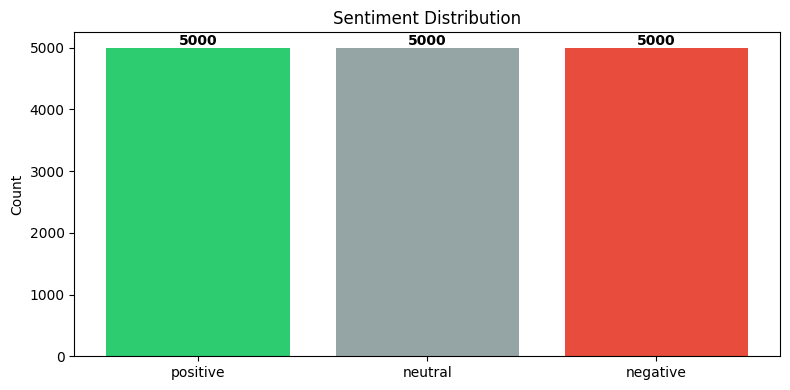

In [3]:
# Load data dari folder data/
DATA_PATH = 'data/gojek_reviews_final_augmented.csv'

if not os.path.exists(DATA_PATH):
    print(f'❌ File tidak ditemukan: {DATA_PATH}')
    print('\n📁 Files yang ada:')
    if os.path.exists('data'):
        for f in os.listdir('data'):
            print(f'   - data/{f}')
else:
    df = pd.read_csv(DATA_PATH)
    
    print('=' * 60)
    print('📊 DATA OVERVIEW')
    print('=' * 60)
    print(f'Total samples: {len(df):,}')
    print(f'Columns: {df.columns.tolist()}')
    print(f'\n📈 Sentiment Distribution:')
    print(df['sentiment'].value_counts())
    
    # Visualize
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    colors = {'negative': '#e74c3c', 'neutral': '#95a5a6', 'positive': '#2ecc71'}
    counts = df['sentiment'].value_counts()
    bars = ax.bar(counts.index, counts.values, color=[colors[s] for s in counts.index])
    ax.set_title('Sentiment Distribution')
    ax.set_ylabel('Count')
    for bar, count in zip(bars, counts.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                str(count), ha='center', fontweight='bold')
    plt.tight_layout()
    plt.show()

## ⚖️ 3. Prepare Data

In [4]:
# Check if data is already balanced
counts = df['sentiment'].value_counts()
min_count = counts.min()
max_count = counts.max()

if (max_count - min_count) / max_count < 0.1:
    print('✓ Data sudah balanced!')
    df_balanced = df.copy()
else:
    print('⚠️ Melakukan undersampling...')
    df_balanced = pd.DataFrame()
    for sentiment in ['negative', 'neutral', 'positive']:
        df_class = df[df['sentiment'] == sentiment]
        df_sampled = resample(df_class, replace=False, n_samples=min_count, random_state=42)
        df_balanced = pd.concat([df_balanced, df_sampled])
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f'\n📊 Data untuk training: {len(df_balanced):,} samples')
print(df_balanced['sentiment'].value_counts())

✓ Data sudah balanced!

📊 Data untuk training: 15,000 samples
sentiment
positive    5000
neutral     5000
negative    5000
Name: count, dtype: int64


In [5]:
# Label mapping
LABEL_MAP = {'negative': 0, 'neutral': 1, 'positive': 2}
LABEL_NAMES = ['negative', 'neutral', 'positive']
NUM_CLASSES = 3

df_balanced['label'] = df_balanced['sentiment'].map(LABEL_MAP)

# Split: 70% train, 15% val, 15% test
train_df, temp_df = train_test_split(
    df_balanced, test_size=0.3, random_state=42, stratify=df_balanced['label']
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df['label']
)

print('=' * 60)
print('📂 DATA SPLITS')
print('=' * 60)
print(f'Train: {len(train_df):,} samples ({len(train_df)/len(df_balanced)*100:.1f}%)')
print(f'Val:   {len(val_df):,} samples ({len(val_df)/len(df_balanced)*100:.1f}%)')
print(f'Test:  {len(test_df):,} samples ({len(test_df)/len(df_balanced)*100:.1f}%)')

📂 DATA SPLITS
Train: 10,500 samples (70.0%)
Val:   2,250 samples (15.0%)
Test:  2,250 samples (15.0%)


## ⚙️ 4. Configuration

In [ ]:
# === HYPERPARAMETERS ===
# Optimized untuk 5 epochs dengan GPU

CONFIG = {
    # Model
    'model_name': 'indobenchmark/indobert-base-p1',
    'max_length': 128,
    'num_classes': NUM_CLASSES,
    
    # Training - 5 Epochs
    'batch_size': 32,
    'epochs': 5,  # 5 epochs only
    'learning_rate': 2e-5,
    
    # Anti-Overfitting
    'dropout_rate': 0.5,
    'attention_dropout': 0.2,
    'weight_decay': 0.01,
    'label_smoothing': 0.1,
    'warmup_ratio': 0.1,
    'max_grad_norm': 1.0,
    'early_stopping_patience': 5,
    
    # Data Augmentation
    'word_dropout_prob': 0.15,
    
    # Layer Freezing
    'freeze_layers': 10,  # Freeze 10 dari 12 layer
    
    # R-Drop
    'rdrop_alpha': 0.3,
}

print('=' * 60)
print('⚙️  CONFIGURATION - GPU MODE (5 EPOCHS)')
print('=' * 60)
for key, value in CONFIG.items():
    print(f'{key}: {value}')

print(f'   Total estimated: ~{CONFIG["epochs"] * 1} - {CONFIG["epochs"] * 3} minutes')

# Estimate training timeprint('   With GPU, expect ~1-3 minutes per epoch')
print('\n⏱️  ESTIMATED TRAINING TIME:')

⚙️  CONFIGURATION
model_name: indobenchmark/indobert-base-p1
max_length: 128
num_classes: 3
batch_size: 32
epochs: 30
learning_rate: 5e-06
dropout_rate: 0.6
attention_dropout: 0.3
weight_decay: 0.05
label_smoothing: 0.2
warmup_ratio: 0.15
max_grad_norm: 0.5
early_stopping_patience: 7
word_dropout_prob: 0.2
freeze_layers: 9
rdrop_alpha: 0.5


## 📦 5. Dataset & DataLoader

In [7]:
# Load tokenizer
print('Loading tokenizer...')
tokenizer = BertTokenizer.from_pretrained(CONFIG['model_name'])
print(f'✓ Tokenizer loaded: {CONFIG["model_name"]}')

class SentimentDataset(Dataset):
    """Dataset dengan augmentation"""
    
    def __init__(self, texts, labels, tokenizer, max_length=128, 
                 augment=False, word_dropout_prob=0.2):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.augment = augment
        self.word_dropout_prob = word_dropout_prob
    
    def __len__(self):
        return len(self.texts)
    
    def _augment_text(self, text):
        if not self.augment:
            return text
        
        text = str(text)
        words = text.split()
        
        if len(words) <= 3:
            return text
        
        aug_type = random.random()
        
        if aug_type < 0.3:
            # Word dropout
            words = [w for w in words if random.random() > self.word_dropout_prob]
        elif aug_type < 0.5:
            # Word swap
            if len(words) > 2:
                idx = random.randint(0, len(words) - 2)
                words[idx], words[idx + 1] = words[idx + 1], words[idx]
        elif aug_type < 0.7:
            # Random deletion
            if len(words) > 4:
                del_idx = random.randint(0, len(words) - 1)
                words.pop(del_idx)
        
        return ' '.join(words) if words else text
    
    def __getitem__(self, idx):
        text = self._augment_text(self.texts[idx])
        
        encoding = self.tokenizer.encode_plus(
            str(text),
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

Loading tokenizer...


vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

✓ Tokenizer loaded: indobenchmark/indobert-base-p1


In [8]:
# Create datasets
train_dataset = SentimentDataset(
    train_df['content_clean'].values,
    train_df['label'].values,
    tokenizer,
    max_length=CONFIG['max_length'],
    augment=True,
    word_dropout_prob=CONFIG['word_dropout_prob']
)

val_dataset = SentimentDataset(
    val_df['content_clean'].values,
    val_df['label'].values,
    tokenizer,
    max_length=CONFIG['max_length'],
    augment=False
)

test_dataset = SentimentDataset(
    test_df['content_clean'].values,
    test_df['label'].values,
    tokenizer,
    max_length=CONFIG['max_length'],
    augment=False
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print(f'\n✓ Datasets created:')
print(f'  Train: {len(train_dataset)} samples, {len(train_loader)} batches')
print(f'  Val:   {len(val_dataset)} samples, {len(val_loader)} batches')
print(f'  Test:  {len(test_dataset)} samples, {len(test_loader)} batches')


✓ Datasets created:
  Train: 10500 samples, 328 batches
  Val:   2250 samples, 71 batches
  Test:  2250 samples, 71 batches


## 🧠 6. Model

In [9]:
class IndoBERTSentimentClassifier(nn.Module):
    """
    IndoBERT dengan regularisasi maksimal:
    - Freeze 9/12 layer BERT
    - Multiple dropout
    - Simple classifier
    """
    
    def __init__(self, model_name, num_classes, dropout_rate=0.6, 
                 attention_dropout=0.3, freeze_layers=9):
        super(IndoBERTSentimentClassifier, self).__init__()
        
        # Load pretrained BERT
        self.bert = BertModel.from_pretrained(model_name)
        self.hidden_size = self.bert.config.hidden_size
        
        # Freeze embeddings
        for param in self.bert.embeddings.parameters():
            param.requires_grad = False
        
        # Freeze first N encoder layers
        for i in range(freeze_layers):
            for param in self.bert.encoder.layer[i].parameters():
                param.requires_grad = False
        
        # Add dropout to attention in unfrozen layers
        for i in range(freeze_layers, 12):
            self.bert.encoder.layer[i].attention.self.dropout = nn.Dropout(attention_dropout)
            self.bert.encoder.layer[i].attention.output.dropout = nn.Dropout(attention_dropout)
        
        print(f'✓ Froze embeddings and first {freeze_layers} encoder layers')
        print(f'  Only layers {freeze_layers}-11 are trainable (3 layers)')
        
        # Regularization
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.layer_norm = nn.LayerNorm(self.hidden_size)
        
        # Simple classifier
        self.fc = nn.Linear(self.hidden_size, num_classes)
        
        # Initialize
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        pooled_output = outputs.pooler_output
        
        x = self.layer_norm(pooled_output)
        x = self.dropout1(x)
        
        if self.training:
            x = self.dropout2(x)
        
        logits = self.fc(x)
        
        return logits

In [10]:
# Initialize model
print('Loading IndoBERT model...')
model = IndoBERTSentimentClassifier(
    model_name=CONFIG['model_name'],
    num_classes=CONFIG['num_classes'],
    dropout_rate=CONFIG['dropout_rate'],
    attention_dropout=CONFIG['attention_dropout'],
    freeze_layers=CONFIG['freeze_layers']
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f'\n✓ Model loaded to {device}')
print(f'  Total parameters: {total_params:,}')
print(f'  Trainable: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)')
print(f'  Frozen: {frozen_params:,} ({frozen_params/total_params*100:.1f}%)')

Loading IndoBERT model...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

✓ Froze embeddings and first 9 encoder layers
  Only layers 9-11 are trainable (3 layers)

✓ Model loaded to cuda
  Total parameters: 124,445,187
  Trainable: 21,858,051 (17.6%)
  Frozen: 102,587,136 (82.4%)


## 📉 7. Loss, Optimizer & Scheduler

In [11]:
# Loss function dengan label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG['label_smoothing'])

# Optimizer - hanya untuk trainable parameters
no_decay = ['bias', 'LayerNorm.weight', 'layer_norm.weight']
trainable_params_list = [(n, p) for n, p in model.named_parameters() if p.requires_grad]

optimizer_grouped_parameters = [
    {
        'params': [p for n, p in trainable_params_list if not any(nd in n for nd in no_decay)],
        'weight_decay': CONFIG['weight_decay']
    },
    {
        'params': [p for n, p in trainable_params_list if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0
    }
]

optimizer = AdamW(optimizer_grouped_parameters, lr=CONFIG['learning_rate'])

# Scheduler
total_steps = len(train_loader) * CONFIG['epochs']
warmup_steps = int(total_steps * CONFIG['warmup_ratio'])

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f'✓ Optimizer: AdamW (lr={CONFIG["learning_rate"]}, wd={CONFIG["weight_decay"]})')
print(f'✓ Scheduler: Linear warmup ({warmup_steps} warmup, {total_steps} total)')
print(f'✓ Loss: CrossEntropy with label_smoothing={CONFIG["label_smoothing"]}')

✓ Optimizer: AdamW (lr=5e-06, wd=0.05)
✓ Scheduler: Linear warmup (1476 warmup, 9840 total)
✓ Loss: CrossEntropy with label_smoothing=0.2


## 🏋️ 8. Training Functions

In [12]:
def compute_kl_loss(p, q):
    """KL divergence for R-Drop"""
    p_loss = F.kl_div(F.log_softmax(p, dim=-1), F.softmax(q, dim=-1), reduction='batchmean')
    q_loss = F.kl_div(F.log_softmax(q, dim=-1), F.softmax(p, dim=-1), reduction='batchmean')
    return (p_loss + q_loss) / 2

def train_epoch(model, dataloader, criterion, optimizer, scheduler, device, 
                max_grad_norm, rdrop_alpha=0.5):
    """Train dengan R-Drop regularization"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    progress_bar = tqdm(dataloader, desc='Training', leave=False)
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        # R-Drop: 2 forward passes
        logits1 = model(input_ids, attention_mask)
        logits2 = model(input_ids, attention_mask)
        
        # Cross entropy loss
        ce_loss = (criterion(logits1, labels) + criterion(logits2, labels)) / 2
        
        # KL divergence loss
        kl_loss = compute_kl_loss(logits1, logits2)
        
        # Total loss
        loss = ce_loss + rdrop_alpha * kl_loss
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        avg_logits = (logits1 + logits2) / 2
        preds = torch.argmax(avg_logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1

def evaluate(model, dataloader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1, all_preds, all_labels

class EarlyStopping:
    """Early stopping dengan gap monitoring"""
    
    def __init__(self, patience=7, min_delta=0.001, mode='max', max_gap=0.08):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.max_gap = max_gap
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model = None
        self.best_gap = float('inf')
    
    def __call__(self, score, model, train_score=None):
        if self.mode == 'max':
            is_improvement = self.best_score is None or score > self.best_score + self.min_delta
        else:
            is_improvement = self.best_score is None or score < self.best_score - self.min_delta
        
        if is_improvement:
            self.best_score = score
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            if train_score is not None:
                self.best_gap = train_score - score
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        
        return self.early_stop

print('✓ Training functions defined')

✓ Training functions defined


## 🚀 9. Training Loop

In [13]:
# Training history
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': [],
    'gap': [],
    'epoch_time': [],
    'memory_used_mb': [],
    'power_draw_w': []
}

early_stopping = EarlyStopping(
    patience=CONFIG['early_stopping_patience'], 
    mode='max',
    max_gap=0.08
)

print('=' * 60)
print('🚀 TRAINING STARTED')
print('=' * 60)
print(f'Device: {device}')
print(f'Epochs: {CONFIG["epochs"]} | Patience: {CONFIG["early_stopping_patience"]}')
print(f'LR: {CONFIG["learning_rate"]} | Batch: {CONFIG["batch_size"]}')
print(f'Frozen Layers: {CONFIG["freeze_layers"]}/12 | Dropout: {CONFIG["dropout_rate"]}')
print('-' * 60)

# Show initial GPU stats
if torch.cuda.is_available():
    gpu_stats = get_gpu_stats()
    if gpu_stats:
        print(f'🎮 GPU: {torch.cuda.get_device_name(0)}')
        print(f'   Memory: {gpu_stats["memory_used_mb"]:.0f}/{gpu_stats["memory_total_mb"]:.0f} MB')
        print(f'   Power: {gpu_stats["power_draw_w"]:.1f} W | Temp: {gpu_stats["temperature_c"]:.0f}°C')
print('-' * 60)

best_val_f1 = 0
best_epoch = 0
best_gap = float('inf')

# Start GPU monitoring
gpu_monitor.start()
training_start_time = datetime.now()

for epoch in range(CONFIG['epochs']):
    epoch_start = time.time()
    print(f'\n📍 Epoch {epoch + 1}/{CONFIG["epochs"]}')
    
    # Train
    train_loss, train_acc, train_f1 = train_epoch(
        model, train_loader, criterion, optimizer, scheduler, 
        device, CONFIG['max_grad_norm'], CONFIG['rdrop_alpha']
    )
    
    # Sample GPU stats after training
    gpu_monitor.sample()
    
    # Validate
    val_loss, val_acc, val_f1, _, _ = evaluate(
        model, val_loader, criterion, device
    )
    
    gap = train_acc - val_acc
    epoch_time = time.time() - epoch_start
    
    # Get current GPU stats
    current_memory = 0
    current_power = 0
    if torch.cuda.is_available():
        current_memory = torch.cuda.memory_allocated(0) / 1024**2
        current_power = get_gpu_power()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['gap'].append(gap)
    history['epoch_time'].append(epoch_time)
    history['memory_used_mb'].append(current_memory)
    history['power_draw_w'].append(current_power)
    
    # Print metrics
    print(f'  Train - Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}')
    print(f'  Val   - Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}')
    
    # Track best
    if val_f1 > best_val_f1 and gap < 0.10:
        best_val_f1 = val_f1
        best_epoch = epoch + 1
        best_gap = gap
        print(f'  ⭐ New best! F1: {val_f1:.4f}, Gap: {gap*100:.2f}%')
    
    # Gap status
    gap_status = '✅ Good' if gap < 0.05 else '⚡ OK' if gap < 0.10 else '⚠️ High'
    print(f'  📊 Gap: {gap*100:.2f}% {gap_status}')
    print(f'  ⏱️  Time: {epoch_time:.1f}s | 💾 Mem: {current_memory:.0f}MB | ⚡ Power: {current_power:.1f}W')
    
    # Early stopping
    if early_stopping(val_f1, model, train_acc):
        print(f'\n🛑 Early stopping at epoch {epoch + 1}')
        break

# Stop GPU monitoring
gpu_monitor.stop()
training_end_time = datetime.now()
total_time = training_end_time - training_start_time

# Load best model
if early_stopping.best_model is not None:
    model.load_state_dict(early_stopping.best_model)

# Get GPU summary
gpu_summary = gpu_monitor.get_summary()

print('\n' + '=' * 60)
print('✅ TRAINING COMPLETED')
print('=' * 60)
print(f'  Best epoch: {best_epoch}')
print(f'  Best Val F1: {best_val_f1:.4f}')
print(f'  Best Gap: {best_gap*100:.2f}%')
print()
print('⏱️  TIME STATISTICS:')
print(f'  Total Duration: {gpu_summary["duration_formatted"]}')
print(f'  Avg Time/Epoch: {np.mean(history["epoch_time"]):.1f}s')
print()
print('💾 MEMORY STATISTICS:')
print(f'  Peak Memory: {gpu_summary["peak_memory_mb"]:.0f} MB')
print(f'  Avg Memory: {gpu_summary["avg_memory_mb"]:.0f} MB')
print()
print('⚡ POWER STATISTICS:')
print(f'  Avg Power: {gpu_summary["avg_power_w"]:.1f} W')
print(f'  Max Power: {gpu_summary["max_power_w"]:.1f} W')
print(f'  Total Energy: {gpu_summary["total_energy_wh"]:.2f} Wh ({gpu_summary["total_energy_kwh"]:.4f} kWh)')
print('=' * 60)

🚀 TRAINING STARTED
Device: cuda
Epochs: 30 | Patience: 7
LR: 5e-06 | Batch: 32
Frozen Layers: 9/12 | Dropout: 0.6
------------------------------------------------------------
🎮 GPU: NVIDIA GeForce RTX 4070
   Memory: 1387/12282 MB
   Power: 31.3 W | Temp: 35°C
------------------------------------------------------------

📍 Epoch 1/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 4.2205 | Acc: 0.3498 | F1: 0.3428
  Val   - Loss: 1.1809 | Acc: 0.4724 | F1: 0.4743
  ⭐ New best! F1: 0.4743, Gap: -12.27%
  📊 Gap: -12.27% ✅ Good
  ⏱️  Time: 68.7s | 💾 Mem: 757MB | ⚡ Power: 188.0W

📍 Epoch 2/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 3.7089 | Acc: 0.4478 | F1: 0.4488
  Val   - Loss: 1.2066 | Acc: 0.5871 | F1: 0.5669
  ⭐ New best! F1: 0.5669, Gap: -13.93%
  📊 Gap: -13.93% ✅ Good
  ⏱️  Time: 69.6s | 💾 Mem: 1247MB | ⚡ Power: 187.6W

📍 Epoch 3/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 3.2876 | Acc: 0.5292 | F1: 0.5299
  Val   - Loss: 1.3343 | Acc: 0.6231 | F1: 0.6130
  ⭐ New best! F1: 0.6130, Gap: -9.40%
  📊 Gap: -9.40% ✅ Good
  ⏱️  Time: 69.6s | 💾 Mem: 1239MB | ⚡ Power: 182.8W

📍 Epoch 4/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 2.8531 | Acc: 0.5766 | F1: 0.5787
  Val   - Loss: 1.2202 | Acc: 0.6653 | F1: 0.6654
  ⭐ New best! F1: 0.6654, Gap: -8.87%
  📊 Gap: -8.87% ✅ Good
  ⏱️  Time: 69.7s | 💾 Mem: 1246MB | ⚡ Power: 187.6W

📍 Epoch 5/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 2.5513 | Acc: 0.5823 | F1: 0.5844
  Val   - Loss: 1.1541 | Acc: 0.6818 | F1: 0.6869
  ⭐ New best! F1: 0.6869, Gap: -9.95%
  📊 Gap: -9.95% ✅ Good
  ⏱️  Time: 69.4s | 💾 Mem: 1238MB | ⚡ Power: 186.3W

📍 Epoch 6/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 2.2924 | Acc: 0.5948 | F1: 0.5974
  Val   - Loss: 1.0856 | Acc: 0.6769 | F1: 0.6804
  📊 Gap: -8.21% ✅ Good
  ⏱️  Time: 69.5s | 💾 Mem: 1247MB | ⚡ Power: 185.2W

📍 Epoch 7/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 2.0807 | Acc: 0.6087 | F1: 0.6108
  Val   - Loss: 1.0674 | Acc: 0.6796 | F1: 0.6843
  📊 Gap: -7.08% ✅ Good
  ⏱️  Time: 69.9s | 💾 Mem: 1247MB | ⚡ Power: 184.3W

📍 Epoch 8/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.9301 | Acc: 0.6135 | F1: 0.6155
  Val   - Loss: 1.0381 | Acc: 0.6782 | F1: 0.6781
  📊 Gap: -6.48% ✅ Good
  ⏱️  Time: 70.0s | 💾 Mem: 1247MB | ⚡ Power: 181.2W

📍 Epoch 9/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.8318 | Acc: 0.6158 | F1: 0.6176
  Val   - Loss: 1.0059 | Acc: 0.6884 | F1: 0.6934
  ⭐ New best! F1: 0.6934, Gap: -7.27%
  📊 Gap: -7.27% ✅ Good
  ⏱️  Time: 70.0s | 💾 Mem: 1247MB | ⚡ Power: 180.6W

📍 Epoch 10/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.7464 | Acc: 0.6214 | F1: 0.6239
  Val   - Loss: 1.0253 | Acc: 0.6680 | F1: 0.6527
  📊 Gap: -4.66% ✅ Good
  ⏱️  Time: 69.5s | 💾 Mem: 1242MB | ⚡ Power: 185.6W

📍 Epoch 11/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.6888 | Acc: 0.6185 | F1: 0.6205
  Val   - Loss: 0.9729 | Acc: 0.6969 | F1: 0.7013
  ⭐ New best! F1: 0.7013, Gap: -7.84%
  📊 Gap: -7.84% ✅ Good
  ⏱️  Time: 70.6s | 💾 Mem: 1242MB | ⚡ Power: 180.6W

📍 Epoch 12/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.6371 | Acc: 0.6297 | F1: 0.6326
  Val   - Loss: 0.9680 | Acc: 0.6902 | F1: 0.6926
  📊 Gap: -6.06% ✅ Good
  ⏱️  Time: 70.1s | 💾 Mem: 1241MB | ⚡ Power: 181.8W

📍 Epoch 13/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.6031 | Acc: 0.6295 | F1: 0.6318
  Val   - Loss: 0.9834 | Acc: 0.6804 | F1: 0.6767
  📊 Gap: -5.10% ✅ Good
  ⏱️  Time: 69.6s | 💾 Mem: 1241MB | ⚡ Power: 188.7W

📍 Epoch 14/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.5791 | Acc: 0.6296 | F1: 0.6315
  Val   - Loss: 0.9644 | Acc: 0.6858 | F1: 0.6813
  📊 Gap: -5.62% ✅ Good
  ⏱️  Time: 70.0s | 💾 Mem: 1241MB | ⚡ Power: 179.0W

📍 Epoch 15/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.5374 | Acc: 0.6325 | F1: 0.6351
  Val   - Loss: 0.9499 | Acc: 0.7000 | F1: 0.7031
  ⭐ New best! F1: 0.7031, Gap: -6.75%
  📊 Gap: -6.75% ✅ Good
  ⏱️  Time: 69.3s | 💾 Mem: 1241MB | ⚡ Power: 185.6W

📍 Epoch 16/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.4998 | Acc: 0.6387 | F1: 0.6411
  Val   - Loss: 0.9436 | Acc: 0.7018 | F1: 0.7051
  ⭐ New best! F1: 0.7051, Gap: -6.31%
  📊 Gap: -6.31% ✅ Good
  ⏱️  Time: 69.6s | 💾 Mem: 1241MB | ⚡ Power: 186.1W

📍 Epoch 17/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.4805 | Acc: 0.6345 | F1: 0.6367
  Val   - Loss: 0.9431 | Acc: 0.6991 | F1: 0.7023
  📊 Gap: -6.46% ✅ Good
  ⏱️  Time: 69.3s | 💾 Mem: 1243MB | ⚡ Power: 183.8W

📍 Epoch 18/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.4544 | Acc: 0.6415 | F1: 0.6439
  Val   - Loss: 0.9357 | Acc: 0.6991 | F1: 0.7042
  📊 Gap: -5.76% ✅ Good
  ⏱️  Time: 69.3s | 💾 Mem: 1243MB | ⚡ Power: 184.9W

📍 Epoch 19/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.4345 | Acc: 0.6482 | F1: 0.6507
  Val   - Loss: 0.9304 | Acc: 0.7062 | F1: 0.7112
  ⭐ New best! F1: 0.7112, Gap: -5.80%
  📊 Gap: -5.80% ✅ Good
  ⏱️  Time: 69.4s | 💾 Mem: 1243MB | ⚡ Power: 184.3W

📍 Epoch 20/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.4149 | Acc: 0.6503 | F1: 0.6527
  Val   - Loss: 0.9219 | Acc: 0.7022 | F1: 0.7057
  📊 Gap: -5.19% ✅ Good
  ⏱️  Time: 69.5s | 💾 Mem: 1239MB | ⚡ Power: 187.2W

📍 Epoch 21/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.4063 | Acc: 0.6465 | F1: 0.6488
  Val   - Loss: 0.9241 | Acc: 0.7040 | F1: 0.7086
  📊 Gap: -5.75% ✅ Good
  ⏱️  Time: 69.5s | 💾 Mem: 1239MB | ⚡ Power: 183.3W

📍 Epoch 22/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.3959 | Acc: 0.6488 | F1: 0.6507
  Val   - Loss: 0.9288 | Acc: 0.6956 | F1: 0.6966
  📊 Gap: -4.67% ✅ Good
  ⏱️  Time: 69.4s | 💾 Mem: 1239MB | ⚡ Power: 185.7W

📍 Epoch 23/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.3707 | Acc: 0.6549 | F1: 0.6573
  Val   - Loss: 0.9246 | Acc: 0.7044 | F1: 0.7091
  📊 Gap: -4.95% ✅ Good
  ⏱️  Time: 69.5s | 💾 Mem: 1239MB | ⚡ Power: 182.8W

📍 Epoch 24/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.3727 | Acc: 0.6534 | F1: 0.6555
  Val   - Loss: 0.9259 | Acc: 0.6978 | F1: 0.6986
  📊 Gap: -4.44% ✅ Good
  ⏱️  Time: 70.0s | 💾 Mem: 1239MB | ⚡ Power: 182.5W

📍 Epoch 25/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.3515 | Acc: 0.6488 | F1: 0.6514
  Val   - Loss: 0.9212 | Acc: 0.7058 | F1: 0.7103
  📊 Gap: -5.70% ✅ Good
  ⏱️  Time: 69.8s | 💾 Mem: 1239MB | ⚡ Power: 188.4W

📍 Epoch 26/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.3495 | Acc: 0.6522 | F1: 0.6540
  Val   - Loss: 0.9147 | Acc: 0.7089 | F1: 0.7134
  ⭐ New best! F1: 0.7134, Gap: -5.67%
  📊 Gap: -5.67% ✅ Good
  ⏱️  Time: 69.3s | 💾 Mem: 1239MB | ⚡ Power: 189.3W

📍 Epoch 27/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.3418 | Acc: 0.6573 | F1: 0.6598
  Val   - Loss: 0.9142 | Acc: 0.7058 | F1: 0.7091
  📊 Gap: -4.85% ✅ Good
  ⏱️  Time: 69.5s | 💾 Mem: 1248MB | ⚡ Power: 185.0W

📍 Epoch 28/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.3366 | Acc: 0.6622 | F1: 0.6645
  Val   - Loss: 0.9143 | Acc: 0.7080 | F1: 0.7116
  📊 Gap: -4.58% ✅ Good
  ⏱️  Time: 69.4s | 💾 Mem: 1248MB | ⚡ Power: 186.2W

📍 Epoch 29/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.3384 | Acc: 0.6552 | F1: 0.6577
  Val   - Loss: 0.9132 | Acc: 0.7084 | F1: 0.7131
  📊 Gap: -5.32% ✅ Good
  ⏱️  Time: 69.5s | 💾 Mem: 1248MB | ⚡ Power: 184.5W

📍 Epoch 30/30


Training:   0%|          | 0/328 [00:00<?, ?it/s]

  Train - Loss: 1.3302 | Acc: 0.6597 | F1: 0.6620
  Val   - Loss: 0.9120 | Acc: 0.7076 | F1: 0.7120
  📊 Gap: -4.79% ✅ Good
  ⏱️  Time: 69.3s | 💾 Mem: 1248MB | ⚡ Power: 186.5W

✅ TRAINING COMPLETED
  Best epoch: 26
  Best Val F1: 0.7134
  Best Gap: -5.67%

⏱️  TIME STATISTICS:
  Total Duration: 0:34:49
  Avg Time/Epoch: 69.6s

💾 MEMORY STATISTICS:
  Peak Memory: 2776 MB
  Avg Memory: 1227 MB

⚡ POWER STATISTICS:
  Avg Power: 182.7 W
  Max Power: 188.6 W
  Total Energy: 106.01 Wh (0.1060 kWh)


## 📈 10. Training Visualization & Resource Usage

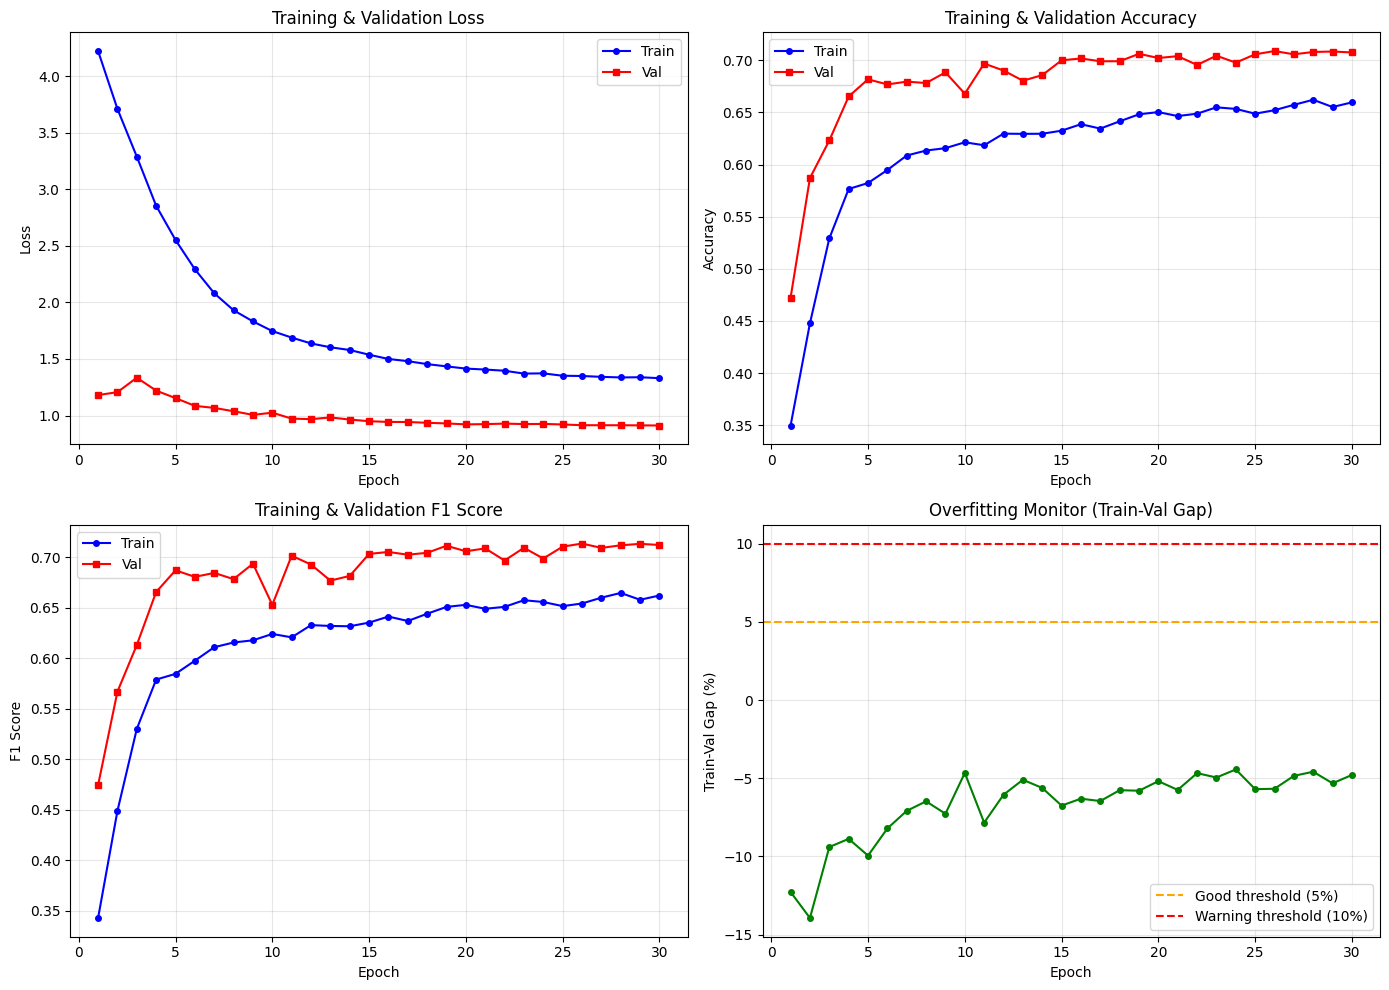

✓ Saved: training_history.png


In [14]:
# =====================================================
# FIGURE 1: Training Metrics
# =====================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
epochs_range = range(1, len(history['train_loss']) + 1)

# Loss
axes[0, 0].plot(epochs_range, history['train_loss'], 'b-o', label='Train', markersize=4)
axes[0, 0].plot(epochs_range, history['val_loss'], 'r-s', label='Val', markersize=4)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training & Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(epochs_range, history['train_acc'], 'b-o', label='Train', markersize=4)
axes[0, 1].plot(epochs_range, history['val_acc'], 'r-s', label='Val', markersize=4)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training & Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1 Score
axes[1, 0].plot(epochs_range, history['train_f1'], 'b-o', label='Train', markersize=4)
axes[1, 0].plot(epochs_range, history['val_f1'], 'r-s', label='Val', markersize=4)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('Training & Validation F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Gap
axes[1, 1].plot(epochs_range, [g*100 for g in history['gap']], 'g-o', markersize=4)
axes[1, 1].axhline(y=5, color='orange', linestyle='--', label='Good threshold (5%)')
axes[1, 1].axhline(y=10, color='red', linestyle='--', label='Warning threshold (10%)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Train-Val Gap (%)')
axes[1, 1].set_title('Overfitting Monitor (Train-Val Gap)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: training_history.png')

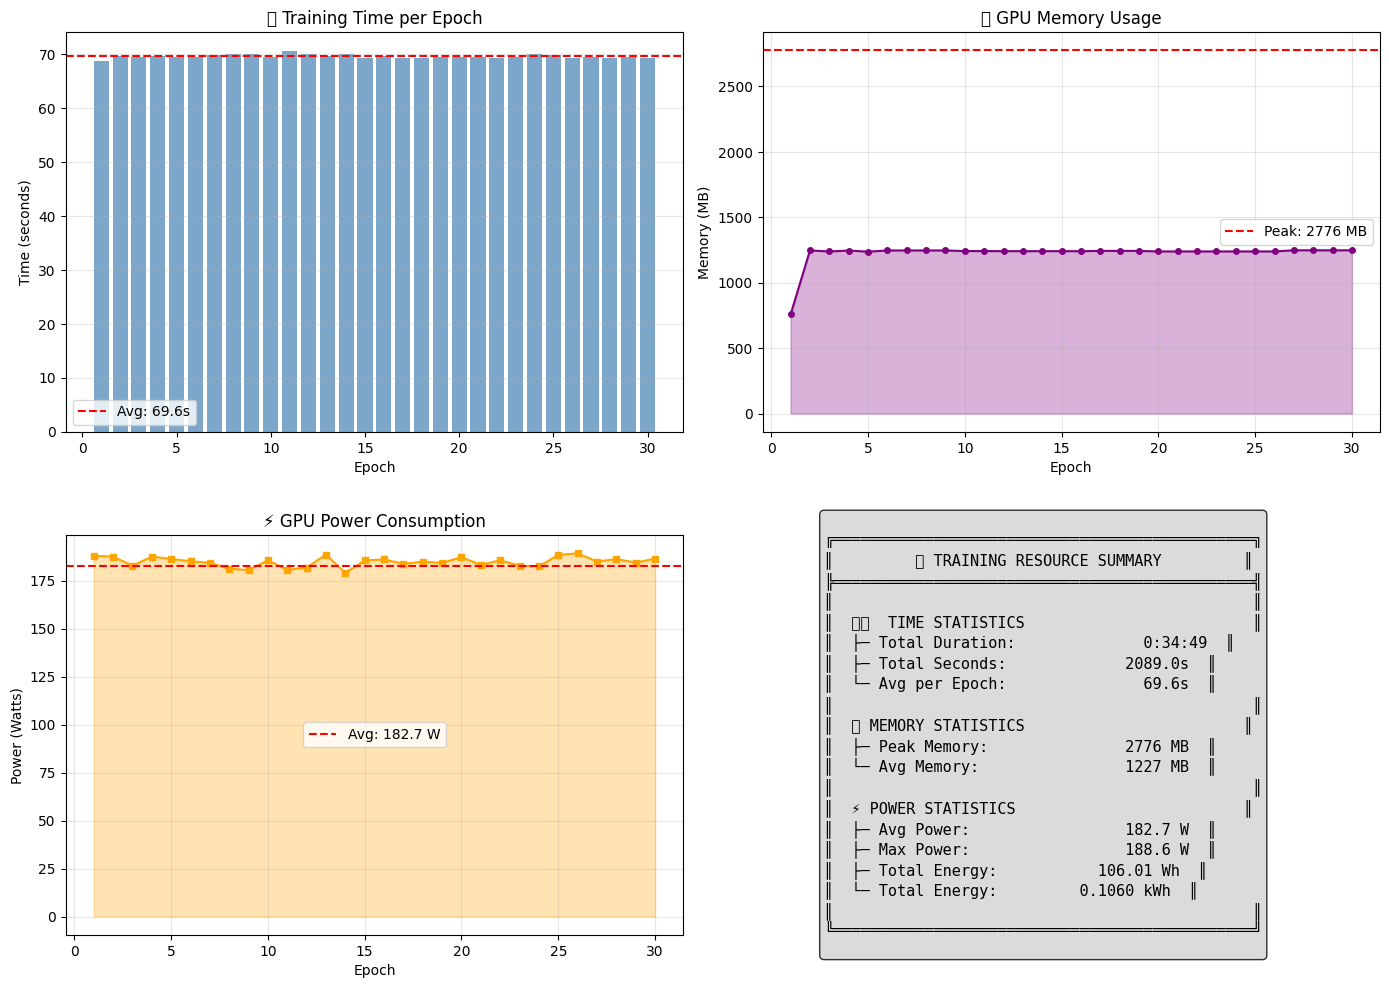

✓ Saved: resource_usage.png


In [ ]:
# =====================================================
# FIGURE 2: Resource Usage (Time, Memory, Power)
# =====================================================

# Electricity cost estimation (Indonesia average: Rp 1.444,70/kWh for 900VA)
ELECTRICITY_RATE_IDR = 1444.70  # Rp per kWh
electricity_cost_idr = gpu_summary['total_energy_kwh'] * ELECTRICITY_RATE_IDR

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
epochs_range = range(1, len(history['epoch_time']) + 1)

# Time per epoch
axes[0, 0].bar(epochs_range, history['epoch_time'], color='steelblue', alpha=0.7)
axes[0, 0].axhline(y=np.mean(history['epoch_time']), color='red', linestyle='--', 
                   label=f'Avg: {np.mean(history["epoch_time"]):.1f}s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Time (seconds)')
axes[0, 0].set_title('⏱️ Training Time per Epoch')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Memory usage
if any(history['memory_used_mb']):
    axes[0, 1].plot(epochs_range, history['memory_used_mb'], 'purple', marker='o', markersize=6)
    axes[0, 1].axhline(y=gpu_summary['peak_memory_mb'], color='red', linestyle='--', 
                       label=f'Peak: {gpu_summary["peak_memory_mb"]:.0f} MB')
    axes[0, 1].fill_between(epochs_range, 0, history['memory_used_mb'], alpha=0.3, color='purple')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Memory (MB)')
    axes[0, 1].set_title('💾 GPU Memory Usage')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'No GPU Memory Data', ha='center', va='center', fontsize=14)
    axes[0, 1].set_title('💾 GPU Memory Usage')

# Power consumption
if any(history['power_draw_w']):
    axes[0, 2].plot(epochs_range, history['power_draw_w'], 'orange', marker='s', markersize=6)
    axes[0, 2].axhline(y=gpu_summary['avg_power_w'], color='red', linestyle='--', 
                       label=f'Avg: {gpu_summary["avg_power_w"]:.1f} W')
    axes[0, 2].fill_between(epochs_range, 0, history['power_draw_w'], alpha=0.3, color='orange')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Power (Watts)')
    axes[0, 2].set_title('⚡ GPU Power Consumption')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
else:
    axes[0, 2].text(0.5, 0.5, 'No Power Data', ha='center', va='center', fontsize=14)
    axes[0, 2].set_title('⚡ GPU Power Consumption')

# Cumulative energy
if any(history['power_draw_w']):
    cumulative_energy = []
    energy_so_far = 0
    for i, (t, p) in enumerate(zip(history['epoch_time'], history['power_draw_w'])):
        energy_so_far += (p * t / 3600)  # Convert to Wh
        cumulative_energy.append(energy_so_far)
    
    axes[1, 0].plot(epochs_range, cumulative_energy, 'red', marker='^', markersize=6)
    axes[1, 0].fill_between(epochs_range, 0, cumulative_energy, alpha=0.3, color='red')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Energy (Wh)')
    axes[1, 0].set_title('🔋 Cumulative Energy Consumption')
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'No Energy Data', ha='center', va='center', fontsize=14)
    axes[1, 0].set_title('🔋 Cumulative Energy Consumption')

# GPU utilization placeholder (if available)
axes[1, 1].axis('off')
gpu_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A'
gpu_info_text = f"""
╔══════════════════════════════════════════════════╗
║              🎮 GPU INFORMATION                  ║
╠══════════════════════════════════════════════════╣
║                                                  ║
║  GPU: {gpu_name[:40]:>40}  ║
║                                                  ║
║  📊 Training Stats:                              ║
║  ├─ Epochs Completed: {len(history['epoch_time']):>25}  ║
║  ├─ Best Epoch: {best_epoch:>30}  ║
║  └─ Best Val F1: {best_val_f1*100:>27.2f}%  ║
║                                                  ║
╚══════════════════════════════════════════════════╝
"""
axes[1, 1].text(0.05, 0.5, gpu_info_text, fontsize=10, fontfamily='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Summary statistics as text
axes[1, 2].axis('off')
summary_text = f"""
╔══════════════════════════════════════════════════╗
║       📊 GPU TRAINING RESOURCE SUMMARY           ║
╠══════════════════════════════════════════════════╣
║                                                  ║
║  ⏱️  TIME STATISTICS                             ║
║  ├─ Total Duration: {gpu_summary['duration_formatted']:>24}  ║
║  ├─ Total Seconds:  {gpu_summary['duration_seconds']:>21.1f}s  ║
║  └─ Avg per Epoch:  {np.mean(history['epoch_time']):>21.1f}s  ║
║                                                  ║
║  💾 GPU MEMORY STATISTICS                        ║
║  ├─ Peak Memory:    {gpu_summary['peak_memory_mb']:>19.0f} MB  ║
║  └─ Avg Memory:     {gpu_summary['avg_memory_mb']:>19.0f} MB  ║
║                                                  ║
║  ⚡ POWER & ELECTRICITY                          ║
║  ├─ Avg Power:      {gpu_summary['avg_power_w']:>19.1f} W  ║
║  ├─ Max Power:      {gpu_summary['max_power_w']:>19.1f} W  ║
║  ├─ Total Energy:   {gpu_summary['total_energy_wh']:>17.2f} Wh  ║
║  └─ Elec. Cost:     Rp {electricity_cost_idr:>15,.2f}  ║
║                                                  ║
╚══════════════════════════════════════════════════╝
"""
axes[1, 2].text(0.05, 0.5, summary_text, fontsize=10, fontfamily='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.savefig('resource_usage_gpu.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: resource_usage_gpu.png')

## 🧪 11. Evaluation on Test Set

In [16]:
# Evaluate on test set
test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(
    model, test_loader, criterion, device
)

print('=' * 60)
print('🧪 TEST SET EVALUATION')
print('=' * 60)
print(f'Test Accuracy: {test_acc*100:.2f}%')
print(f'Test F1 Score: {test_f1*100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

# Classification report
print('\n📊 Classification Report:')
print(classification_report(test_labels, test_preds, target_names=LABEL_NAMES))

🧪 TEST SET EVALUATION
Test Accuracy: 71.91%
Test F1 Score: 72.29%
Test Loss: 0.9009

📊 Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.70      0.68       750
     neutral       0.62      0.67      0.64       750
    positive       0.90      0.79      0.84       750

    accuracy                           0.72      2250
   macro avg       0.73      0.72      0.72      2250
weighted avg       0.73      0.72      0.72      2250



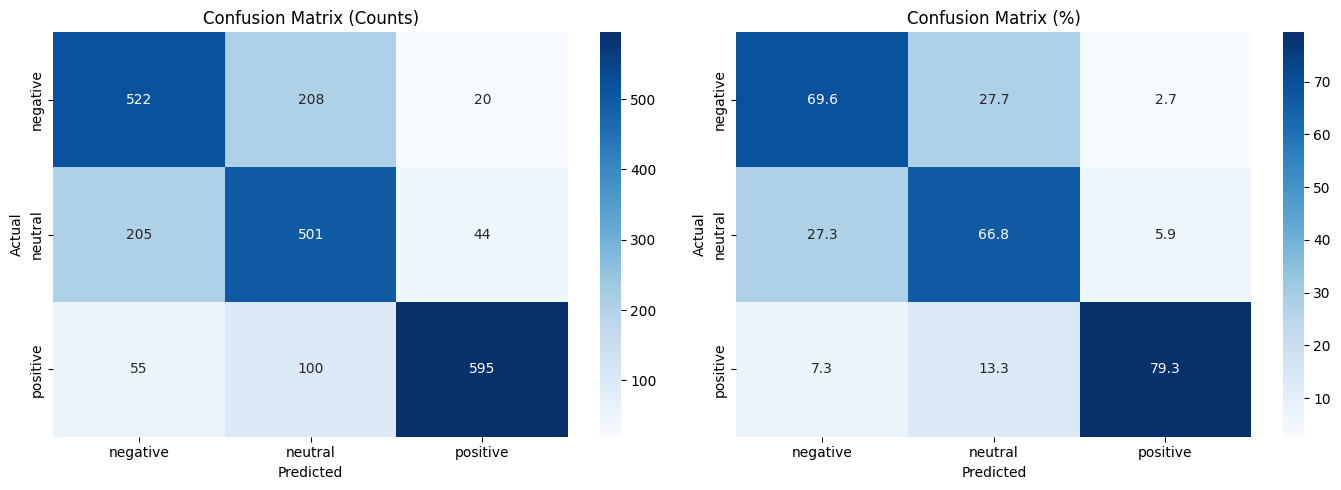

✓ Saved: confusion_matrix.png


In [17]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=LABEL_NAMES, yticklabels=LABEL_NAMES, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix (Counts)')

# Percentages
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=LABEL_NAMES, yticklabels=LABEL_NAMES, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (%)')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: confusion_matrix.png')

## 💾 12. Save Model

In [18]:
# Create models directory
os.makedirs('models', exist_ok=True)

# Save model
model_path = 'models/indobert_sentiment_3class.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'label_map': LABEL_MAP,
    'label_names': LABEL_NAMES,
    'test_accuracy': test_acc,
    'test_f1': test_f1,
    'best_val_f1': best_val_f1,
    'best_gap': best_gap,
    'history': history,
}, model_path)
print(f'✓ Model saved: {model_path}')

# Save tokenizer
tokenizer.save_pretrained('models/tokenizer')
print(f'✓ Tokenizer saved: models/tokenizer/')

# Save history
with open('models/training_history.json', 'w') as f:
    json.dump(history, f, indent=2)
print(f'✓ History saved: models/training_history.json')

# List saved files
print('\n📁 Saved files:')
for root, dirs, files in os.walk('models'):
    for file in files:
        filepath = os.path.join(root, file)
        size = os.path.getsize(filepath) / (1024*1024)
        print(f'   {filepath} ({size:.2f} MB)')

✓ Model saved: models/indobert_sentiment_3class.pt
✓ Tokenizer saved: models/tokenizer/
✓ History saved: models/training_history.json

📁 Saved files:
   models\indobert_sentiment_3class.pt (474.81 MB)
   models\training_history.json (0.01 MB)
   models\tokenizer\special_tokens_map.json (0.00 MB)
   models\tokenizer\tokenizer_config.json (0.00 MB)
   models\tokenizer\vocab.txt (0.25 MB)


## 🔮 13. Inference Demo

In [19]:
def predict_sentiment(text, model, tokenizer, device, label_names):
    """Predict sentiment untuk satu teks"""
    model.eval()
    
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()
    
    return {
        'sentiment': label_names[pred],
        'confidence': probs[0][pred].item(),
        'probabilities': {
            label_names[i]: probs[0][i].item() 
            for i in range(len(label_names))
        }
    }

# Test
test_reviews = [
    "Aplikasi gojek sangat membantu, driver ramah dan cepat",
    "Driver nya lama banget, udah nunggu 1 jam gak datang",
    "Biasa aja sih aplikasinya",
    "Pelayanan buruk, tidak akan pakai lagi",
    "Mantap, makanan sampai dengan selamat dan masih hangat",
]

print('=' * 60)
print('🔮 INFERENCE DEMO')
print('=' * 60)

for review in test_reviews:
    result = predict_sentiment(review, model, tokenizer, device, LABEL_NAMES)
    emoji = {'negative': '😠', 'neutral': '😐', 'positive': '😊'}[result['sentiment']]
    print(f'\n📝 "{review[:50]}..."' if len(review) > 50 else f'\n📝 "{review}"')
    print(f'   {emoji} {result["sentiment"].upper()} ({result["confidence"]*100:.1f}%)')

🔮 INFERENCE DEMO

📝 "Aplikasi gojek sangat membantu, driver ramah dan c..."
   😊 POSITIVE (97.7%)

📝 "Driver nya lama banget, udah nunggu 1 jam gak data..."
   😠 NEGATIVE (81.4%)

📝 "Biasa aja sih aplikasinya"
   😊 POSITIVE (76.6%)

📝 "Pelayanan buruk, tidak akan pakai lagi"
   😠 NEGATIVE (88.9%)

📝 "Mantap, makanan sampai dengan selamat dan masih ha..."
   😊 POSITIVE (96.8%)


## 📊 14. Final Summary

In [ ]:
final_gap = history['train_acc'][-1] - history['val_acc'][-1]
min_gap = min(history['gap'])

# Electricity cost estimation (Indonesia average: Rp 1.444,70/kWh for 900VA)
ELECTRICITY_RATE_IDR = 1444.70  # Rp per kWh
electricity_cost_idr = gpu_summary['total_energy_kwh'] * ELECTRICITY_RATE_IDR

# Get GPU name
gpu_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A'

print('=' * 70)
print('📊 FINAL TRAINING SUMMARY - GPU MODE (5 EPOCHS)')
print('=' * 70)

print(f'''
🎯 MODEL PERFORMANCE:
   • Test Accuracy: {test_acc*100:.2f}%
   • Test F1 Score: {test_f1*100:.2f}%
   • Best Val F1: {best_val_f1*100:.2f}%

📈 OVERFITTING CHECK:
   • Final Gap: {final_gap*100:.2f}%
   • Best Gap: {best_gap*100:.2f}%
   • Status: {"✅ Good" if final_gap < 0.05 else "⚠️ Check" if final_gap < 0.10 else "❌ Overfitting"}

⏱️  TIME STATISTICS:
   • Total Training Time: {gpu_summary['duration_formatted']}
   • Average Time per Epoch: {np.mean(history['epoch_time']):.1f} seconds

💾 GPU MEMORY STATISTICS:
   • Peak GPU Memory: {gpu_summary['peak_memory_mb']:.0f} MB
   • Average GPU Memory: {gpu_summary['avg_memory_mb']:.0f} MB

⚡ GPU POWER & ELECTRICITY:
   • GPU Model: {gpu_name}
   • Average Power Draw: {gpu_summary['avg_power_w']:.1f} W
   • Max Power Draw: {gpu_summary['max_power_w']:.1f} W
   • Total Energy: {gpu_summary['total_energy_wh']:.2f} Wh ({gpu_summary['total_energy_kwh']:.4f} kWh)
   • Electricity Cost: Rp {electricity_cost_idr:,.2f}

⚙️ CONFIGURATION:
   • Device: GPU ({gpu_name})
   • Epochs: {CONFIG['epochs']}
   • Batch Size: {CONFIG['batch_size']}
   • Layer Freezing: {CONFIG['freeze_layers']}/12
   • Dropout: {CONFIG['dropout_rate']}
   • Learning Rate: {CONFIG['learning_rate']}

💾 SAVED FILES:
   • models/indobert_sentiment_3class.pt
   • models/tokenizer/
   • models/training_history.json
   • models/training_report_gpu.json
   • training_history.png
   • resource_usage_gpu.png
   • confusion_matrix.png
''')

if test_acc >= 0.70 and final_gap < 0.05:
    print('🎉 GOOD! Model has decent accuracy and generalization for 5 epochs!')
elif test_acc >= 0.70:
    print('⚠️ Decent accuracy but watch for overfitting.')
elif final_gap < 0.05:
    print('✅ Good generalization but accuracy could improve with more epochs.')
else:
    print('💡 Consider more epochs or adjusting hyperparameters.')

print('=' * 70)
print('✅ GPU Training completed!')
print('=' * 70)

# Save complete training report
training_report = {
    'training_mode': 'GPU',
    'device_name': gpu_name,
    'model_performance': {
        'test_accuracy': float(test_acc),
        'test_f1_score': float(test_f1),
        'best_val_f1': float(best_val_f1),
        'best_epoch': best_epoch,
        'final_gap': float(final_gap),
        'best_gap': float(best_gap)
    },
    'resource_usage': {
        'total_duration_seconds': gpu_summary['duration_seconds'],
        'total_duration_formatted': gpu_summary['duration_formatted'],
        'avg_epoch_time_seconds': float(np.mean(history['epoch_time'])),
        'peak_memory_mb': gpu_summary['peak_memory_mb'],
        'avg_memory_mb': gpu_summary['avg_memory_mb'],
        'avg_power_watts': gpu_summary['avg_power_w'],
        'max_power_watts': gpu_summary['max_power_w'],
        'total_energy_wh': gpu_summary['total_energy_wh'],
        'total_energy_kwh': gpu_summary['total_energy_kwh'],
        'electricity_cost_idr': electricity_cost_idr
    },
    'config': CONFIG,
    'history': history
}

with open('models/training_report_gpu.json', 'w') as f:
    json.dump(training_report, f, indent=2)
print('\n✓ Complete training report saved: models/training_report_gpu.json')

📊 FINAL TRAINING SUMMARY

🎯 MODEL PERFORMANCE:
   • Test Accuracy: 71.91%
   • Test F1 Score: 72.29%
   • Best Val F1: 71.34%

📈 OVERFITTING CHECK:
   • Final Gap: -4.79%
   • Best Gap: -5.67%
   • Status: ✅ Good

⏱️  TIME & RESOURCE USAGE:
   • Total Training Time: 0:34:49
   • Average Time per Epoch: 69.6 seconds
   • Peak GPU Memory: 2776 MB
   • Average GPU Memory: 1227 MB
   • Average Power Draw: 182.7 W
   • Max Power Draw: 188.6 W
   • Total Energy Consumed: 106.01 Wh (0.1060 kWh)

⚙️ TECHNIQUES USED:
   • Layer Freezing: 9/12
   • Dropout: 0.6
   • R-Drop Alpha: 0.5
   • Weight Decay: 0.05
   • Label Smoothing: 0.2
   • Learning Rate: 5e-06

💾 SAVED FILES:
   • models/indobert_sentiment_3class.pt
   • models/tokenizer/
   • models/training_history.json
   • training_history.png
   • resource_usage.png
   • confusion_matrix.png

✅ Good generalization but accuracy could improve.
✅ Training completed!

✓ Complete training report saved: models/training_report.json
